# Continuous Time Sphere Model

We model the example of short-lived temperature sensors on the Earth in continuous time, using a combination of a queueing model and point process. Throughout the setup of the model, fix a time $T;$ for each time $t \in [0,T]$ the set of sensors $S_t$ at time $t$ is a set of locations on $\mathbb{S}^2,$ where $|S_t|$ is a random variable, and $S_t(i),$ the location of the $i$th sensor is uniformly sampled from the uniform measure on the sphere.

Perhaps the easiest way to set up the model is via a (FIFO) queueing model, or birth-death process representing the sensors:

- We start with $L_0$ number of sensors, each sampled uniformly from the sphere. 
- Sensors are added to the queue every so often, again sampled uniformly from the sphere. 
- Independently of the creation of new sensors, sensors break down at a perhaps different rate, and leave the queue.

We can model the time between consecutive joining/ exiting of the queue by exponential distributions.


## Queueing Model Implementation
Consider a queueing model whose initial length is $L_0,$ the number of initial sensors we begin with. We assume that the queue processes sensors (physically: sensors break down) in a random time $\sim \text{Exp}(\lambda_1),$ and sensors join the queue with interarrival times distributed according to $\text{Exp}(\lambda_2),$ which are independent of the times it takes for the queue to process the input.

We can simulate this queue in the following way. For a given fixed time $t \in [0,T],$ by the memoryless property of exponential distributions, the time until a sensor leaves the queue is still $X_1 \sim \text{Exp}(\lambda_1)$ and the interarrival time is still distributed according to $X_2 \text{Exp}(\lambda_2).$ Now, the time until one of these two actions occurs is a random variable $Z = \min(X_1,X_2) \sim \text{Exp}(\lambda_1+\lambda_2)$ (which can be checked). Now the probability that a sensor joins the queue first is $\mathbb{P}(X_1 > X_2) = \frac{\lambda_1}{\lambda_1 + \lambda_2},$ and one minus that for the probability that a sensor breaks and leaves the queue. We can then model the process by waiting $\text{Exp}(\lambda_1+\lambda_2)$ amount of time, and with probability $\frac{\lambda_1}{\lambda_1 + \lambda_2},$ adding a new sensor to the queue, or otherwise removing the oldest sensor from the queue.

## Dynamic Network Analysis
The continuous time model allows us to subsample as finely as we want. We keep track of the birth/death of the sensors in an interval tree; for any $t \in [0,T]$ we query the interval tree for the set of points that are present on the sphere at that time, and then create a dynamic network via the delaunay construction, assigining node values via some observation function representing temperature, or another desired quantity, and the edge weights by distance on the sphere.

# Run the Dynamic Network Analysis

In [29]:
from __future__ import division
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import squareform
import importlib
import scipy.spatial as sp

## Load in sphere code
sys.path.append('../2d_graph_example/')
import SphereExample as sphere
import ContinuousTimeSphereModel as ctsm

## Load in d.n. analysis code
sys.path.append('../shared_scripts/')
import graph_fns as gf
import persistence_fns as pf
import sliding_window_fns as sw
from ripser import ripser, plot_dgms
from sklearn import manifold

In [105]:
## Setup Sensor Lifetimes
T = 15 # Period 

obsfn = lambda t, p: sphere.periodic_northsouth_modulated(t,p,T)
edge_wtsfn = lambda hull_obj: sphere.get_edge_wts(hull_obj, alpha = 1.0)

lambda1 = 50
lambda2 = lambda1

sensor_lifetimes = ctsm.get_sensor_lifetimes(2.5*T, lambda1, lambda2)

In [106]:
## Create the Dynamic Network
dynamic_network_samples = 200
ts = np.linspace(0,2*T,dynamic_network_samples)

(node_wts,edge_wts, allpoints) = ctsm.sample_dynamic_network(sensor_lifetimes, ts, obsfn = obsfn,
                                    edge_wtsfn = edge_wtsfn)

In [107]:
## Apply the analysis

# apply phi functions, and scale the weights
phi_node_wts, phi_edge_wts = gf.weight_fn(node_wts, edge_wts, lamda=1, phi=sphere.linear_phi_fn)

# construct the filtrations / simplicial complexes according to our construction
filtration_matrix = list(map(lambda n, e: pf.get_filtration(n, e), phi_node_wts, phi_edge_wts))

# summarize these filtrations using H_0 barcodes
barcodes = list(map(pf.get_rips_complex, filtration_matrix))

In [96]:
## Video of the example

xs = []
for nw in phi_node_wts:
    xs += nw.tolist()
xs = np.array(xs)
nmin = np.min(xs)
nmax = np.max(xs)
plt.figure(figsize=(18, 6))
for i, (pts, nw, dgm) in enumerate(zip(allpoints, phi_node_wts, barcodes)):
    plt.clf()
    ax = plt.gcf().add_subplot(121, projection='3d')
    pts = np.concatenate((pts, np.zeros((2, 3))), 0)
    nw = np.concatenate((nw, np.array([nmin, nmax])))
    p = ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=nw, s=100, cmap=plt.get_cmap("magma"))
    plt.colorbar(p)
    hull = sp.ConvexHull(pts)
    for simplex in hull.simplices:
        ax.plot(pts[simplex, 0], pts[simplex, 1], pts[simplex, 2], 'k-')
    plt.title("Timestep %i"%i)
    plt.subplot(122)
    plot_dgms(dgm, labels=['H0'])
    plt.xlim([4, 12])
    plt.ylim([4, 12])
    plt.title("%i Nodes, %i Dots"%(nw.shape[0]-2, dgm.shape[0]))
    plt.savefig("Images/SphHarmCtsEx/%i.png"%i, bbox_inches='tight')

/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/ripser-0.3.1-py3.6-macosx-10.7-x86_64.egg/ripser/ripser.py:341: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=10.0, right=10.0
  ax.set_xlim([x_down, x_up])
/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/ripser-0.3.1-py3.6-macosx-10.7-x86_64.egg/ripser/ripser.py:342: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=10.0, top=10.0
  ax.set_ylim([y_down, y_up])
/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/ripser-0.3.1-py3.6-macosx-10.7-x86_64.egg/ripser/ripser.py:341: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=10.0, right=10.0
  ax.set_xlim([x_down, x_up])
/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/ripser-0.3.1-py3.6-macosx-10.7-x86_64.egg/ripser/ripser.py:342: UserWarning: At

# Vary Parameters

In [110]:

## Vary Window Length and Dimension
window_length_test_values = np.linspace(0,T,39)[1:]
dim_test_values = range(2,12)

mpers_results = np.zeros((len(window_length_test_values),len(dim_test_values)))
top_diff_results = np.zeros((len(window_length_test_values),len(dim_test_values)))

for i,wl in enumerate(window_length_test_values):
    for j,d in enumerate(dim_test_values):
        print(wl,d)

        # resample dynamic network 
        tau = wl/d
        ts = np.arange(0,2*T,tau) 
        
        (node_wts,edge_wts, allpoints) = ctsm.sample_dynamic_network(sensor_lifetimes, ts, obsfn = obsfn,
                                    edge_wtsfn = edge_wtsfn)
        
        PDs = sphere.apply_pipeline(node_wts,edge_wts, d = d, tau = 1, lamda=1, phi=sphere.linear_phi_fn) # get the PDs
        res = (sphere.get_maximum_persistence(PDs)[1],sphere.get_top_diff_persistence(PDs)[1], sphere.get_num_features(PDs)[1])
        print(res)

        mpers_results[i,j] = res[0]
        top_diff_results[i,j] = res[1]

0.394736842105 2
(0.33753800392150879, 0.092934250831604004, 39)
0.394736842105 3
(0.35328221321105957, 0.067142724990844727, 64)
0.394736842105 4
(0.44311416149139404, 0.0613250732421875, 86)
0.394736842105 5
(0.45936679840087891, 0.050224065780639648, 113)
0.394736842105 6
(0.53889274597167969, 0.067925691604614258, 138)
0.394736842105 7
(0.51633810997009277, 0.018997430801391602, 157)
0.394736842105 8
(0.54789221286773682, 0.021431326866149902, 183)
0.394736842105 9
(0.66315007209777832, 0.067182064056396484, 187)
0.394736842105 10
(0.77455055713653564, 0.12118256092071533, 232)
0.394736842105 11
(0.82363235950469971, 0.16064274311065674, 229)
0.789473684211 2
(0.25341057777404785, 0.051244974136352539, 17)
0.789473684211 3
(0.35407257080078125, 0.073511004447937012, 34)
0.789473684211 4
(0.44486832618713379, 0.038774728775024414, 35)
0.789473684211 5
(0.48803448677062988, 0.063450813293457031, 45)
0.789473684211 6
(0.55910849571228027, 0.094097375869750977, 59)
0.789473684211 7
(0.

(1.0449283123016357, 1.0032734870910645, 2)
5.52631578947 5
(1.434354305267334, 1.0501899719238281, 5)
5.52631578947 6
(1.5012290477752686, 1.0156807899475098, 6)
5.52631578947 7
(1.8937649726867676, 1.5894889831542969, 5)
5.52631578947 8
(2.0856680870056152, 1.4729032516479492, 9)
5.52631578947 9
(2.401287317276001, 1.9302365779876709, 10)
5.52631578947 10
(2.6548774242401123, 2.014477014541626, 9)
5.52631578947 11
(2.7444188594818115, 2.1286609172821045, 10)
5.92105263158 2
(0.080365419387817383, 0.017886877059936523, 2)
5.92105263158 3
(0.37534952163696289, 0.21415424346923828, 2)
5.92105263158 4
(1.1031937599182129, 0.97360515594482422, 2)
5.92105263158 5
(1.2842404842376709, 0.95422983169555664, 5)
5.92105263158 6
(1.4961104393005371, 1.2726168632507324, 3)
5.92105263158 7
(1.857668399810791, 1.3979301452636719, 8)
5.92105263158 8
(2.1537456512451172, 1.8475265502929688, 7)
5.92105263158 9
(2.2167682647705078, 1.8910131454467773, 8)
5.92105263158 10
(2.5593428611755371, 2.25125169

(0, 0, 0)
11.0526315789 3
(0, 0, 0)
11.0526315789 4
(0.15791225433349609, 0.15599370002746582, 2)
11.0526315789 5
(0.26487398147583008, 0.19514799118041992, 2)
11.0526315789 6
(0.59087467193603516, 0.39929485321044922, 2)
11.0526315789 7
(1.0679550170898438, 1.0679550170898438, 1)
11.0526315789 8
(1.3014254570007324, 1.2088143825531006, 2)
11.0526315789 9
(1.5968480110168457, 1.5968480110168457, 1)
11.0526315789 10
(2.0266556739807129, 1.9554543495178223, 3)
11.0526315789 11
(2.238828182220459, 1.8041987419128418, 4)
11.4473684211 2
(0, 0, 0)
11.4473684211 3
(0.062670230865478516, 0.062670230865478516, 1)
11.4473684211 4
(0.049585580825805664, 0.049585580825805664, 1)
11.4473684211 5
(0.41266775131225586, 0.28481245040893555, 2)
11.4473684211 6
(0.50621414184570312, 0.47460746765136719, 2)
11.4473684211 7
(1.0054845809936523, 1.0054845809936523, 1)
11.4473684211 8
(1.2198090553283691, 1.1883020401000977, 2)
11.4473684211 9
(1.5632734298706055, 1.3374381065368652, 4)
11.4473684211 10
(1

/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


<Figure size 640x480 with 0 Axes>

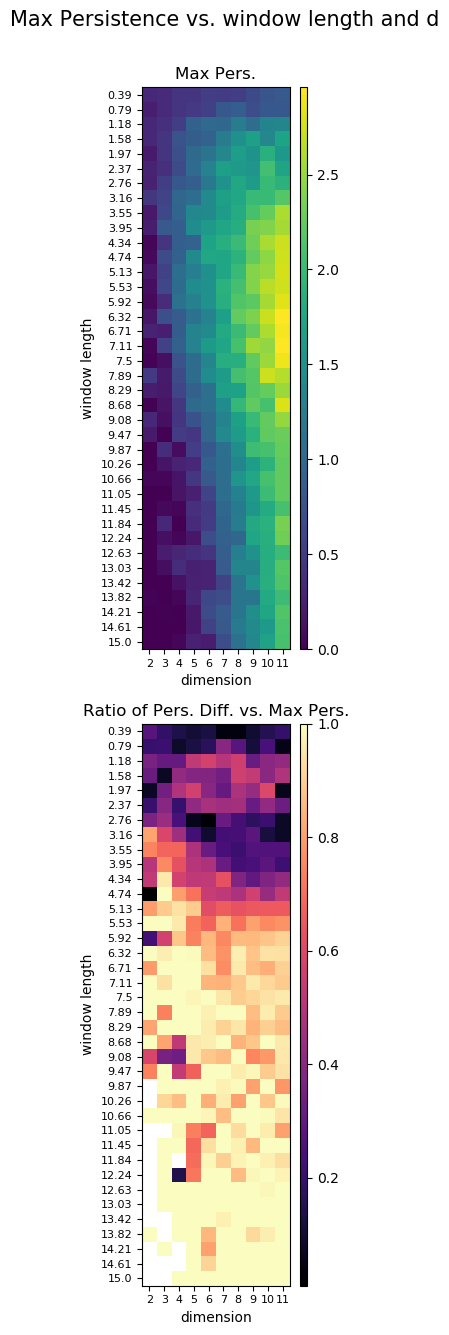

In [112]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.gcf().clear()
fig, axs = plt.subplots(2,1, figsize = (7,14))

ticksize = 8

im1 = axs[0].imshow(mpers_results)

axs[0].set_xlabel('dimension')
axs[0].set_xticks(np.arange(len(dim_test_values)))
axs[0].set_xticklabels(labels = list(dim_test_values),fontsize = ticksize)

axs[0].set_ylabel('window length')
axs[0].set_yticks(np.arange(len(window_length_test_values)))
axs[0].set_yticklabels(labels = list(np.around(window_length_test_values,2)),fontsize = ticksize)

axs[0].set_title('Max Pers.')

divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1,cax1,orientation = 'vertical')

### Do the other plot ###

im2 = axs[1].imshow(np.divide(top_diff_results,mpers_results),cmap = plt.cm.magma)

axs[1].set_xlabel('dimension')
axs[1].set_xticks(np.arange(len(dim_test_values)))
axs[1].set_xticklabels(labels = list(dim_test_values), fontsize = ticksize)


axs[1].set_ylabel('window length')
axs[1].set_yticks(np.arange(len(window_length_test_values)))
axs[1].set_yticklabels(labels = list(np.around(window_length_test_values,2)),fontsize = ticksize)
axs[1].set_title('Ratio of Pers. Diff. vs. Max Pers.')

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2,cax2)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.suptitle('Max Persistence vs. window length and d', fontsize = 15)
plt.savefig('CtsEx:wl{}dim{}T{}'.format(len(window_length_test_values),len(dim_test_values),T))

plt.show()